In [1]:
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio


#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]
#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800


#try setting this as default for histograms
#fig.update_traces(marker_line_width=0.2)

#pio.templates["simple_white"].layout.template.data.Histogram["marker_line_width"] = 0.2


#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

import numpy as np

import sklearn.metrics as metrics
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

colorscale = pc.sequential.Plasma
print(colorscale)
colorscale = [colorscale[0]] + colorscale[3:8]
colorscale

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


['#0d0887', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a']

In [6]:
import pandas as pd
samplesheet = pd.read_excel("../SRA_samplesheet.xlsx", engine="openpyxl")

samples = samplesheet[samplesheet["[custom] experiment"] == "HIV1_unspliced"]["Sample"].values
samples = [sample.replace("Rep1_", "") for sample in samples if ("cell" in sample) & ("Rep1" in sample)]
samples

['RT1_0mM_cell',
 'RT1_8mM_cell',
 'RT1_17mM_cell',
 'RT1_34mM_cell',
 'RT1_57mM_cell',
 'RT1_85mM_cell']

In [11]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd




def xml_to_df(xml_file, reactivity_column_name = "reactivity"):
    try:
        tree = ET.parse(xml_file)
    except:
        print("Could not read in xml file", xml_file, "from sample", sample)
        return 
    
    root = tree.getroot()
    
    transcript_id = root[0].attrib["id"]
    length = root[0].attrib["length"]
    sequence = root[0][0].text.replace("\t", "").replace("\n", "")
    reactivity = np.array(root[0][1].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
    position = list(np.arange(1, len(reactivity)+1))
    tmp_df = pd.DataFrame(np.array([list(sequence), reactivity, position]).T, columns = ["nt", reactivity_column_name, "position"])
    return tmp_df

In [4]:
structure_file = "/vol/projects/pbohn/AnSo_DMS_MaP/references/dimer_canonical_wo_sl_at_210.db"
with open(structure_file) as infile:
    name, sequence, structure = infile.readlines()
structure = np.array(list(structure.strip()))
single_stranded = structure == "."
#structure

In [7]:
def assign_structure(position):
    position = int(position)
    if position < len(single_stranded):
        return single_stranded[position-1]
    else:
        return np.nan


# Normalized reactivities

In [8]:
filename = "siegfried_winsorized"

In [15]:
data_folder = "/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data"


In [91]:
tmp_dfs = []
for sample in samples:
    
    setting = "q22_eq10_ndni"
    nt = "ACGT"
    norm_option = ""
    
    xml = f"{data_folder}/rfcombine/{sample}/RT1_unspliced1/{setting}_{nt}{norm_option}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "nano_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
nano_reactivity_df = pd.concat(tmp_dfs)

Could not read in xml file /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data/rfcombine/RT1_0mM_cell/RT1_unspliced1/q22_eq10_ndni_ACGT/RT1_unspliced1.xml from sample RT1_0mM_cell


In [92]:
data_folder

'/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data'

In [93]:
tmp_dfs = []

minq = "minq33"

for sample in samples:
    setting = "q22_eq10_ndni"
    nt = "ACGT"
    norm_option = ""
    
    xml = f"{data_folder}_illumina/rfcombine_bowtie/{minq}/{sample}/RT1_unspliced1/{setting}_{nt}{norm_option}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "illumina_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
illumina_reactivity_df = pd.concat(tmp_dfs)

Could not read in xml file /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data_illumina/rfcombine_bowtie/minq33/RT1_0mM_cell/RT1_unspliced1/q22_eq10_ndni_ACGT/RT1_unspliced1.xml from sample RT1_0mM_cell


In [94]:
nano_reactivity_df["sample_position"] = nano_reactivity_df["sample"] + "_" + nano_reactivity_df["position"]
illumina_reactivity_df["sample_position"] = illumina_reactivity_df["sample"] + "_" + illumina_reactivity_df["position"]
merged_reactivity_df = pd.merge(nano_reactivity_df, illumina_reactivity_df[["sample_position", "illumina_reactivity"]], on="sample_position")
merged_reactivity_df["DMS_conc"] = merged_reactivity_df["sample"].apply(lambda x: x.split("_")[1])
merged_reactivity_df["illumina_reactivity"] = merged_reactivity_df["illumina_reactivity"].astype(float)
merged_reactivity_df["nano_reactivity"] = merged_reactivity_df["nano_reactivity"].astype(float)
merged_reactivity_df["single_stranded"]  = merged_reactivity_df["position"].apply(lambda x: assign_structure(x))
melted_reactivity_df = pd.melt(merged_reactivity_df, id_vars=["sample_position", "nt", "DMS_conc", "single_stranded"], value_vars=["nano_reactivity", "illumina_reactivity"], var_name="seqtype", value_name='reactivity')

order_dict = {"nt" : ["A", "C", "G", "T"], "DMS_conc": ["8mM", "17mM", "34mM", "57mM", "85mM"]}

In [95]:
order_dict["DMS_conc"] = order_dict["DMS_conc"][1:]

In [96]:
melted_reactivity_df

sample_position nt DMS_conc single_stranded              seqtype  \
0        RT1_8mM_cell_1  G      8mM           False      nano_reactivity   
1        RT1_8mM_cell_2  G      8mM           False      nano_reactivity   
2        RT1_8mM_cell_3  T      8mM           False      nano_reactivity   
3        RT1_8mM_cell_4  C      8mM            True      nano_reactivity   
4        RT1_8mM_cell_5  T      8mM           False      nano_reactivity   
...                 ... ..      ...             ...                  ...   
5355  RT1_85mM_cell_532  C     85mM             NaN  illumina_reactivity   
5356  RT1_85mM_cell_533  A     85mM             NaN  illumina_reactivity   
5357  RT1_85mM_cell_534  T     85mM             NaN  illumina_reactivity   
5358  RT1_85mM_cell_535  C     85mM             NaN  illumina_reactivity   
5359  RT1_85mM_cell_536  C     85mM             NaN  illumina_reactivity   

      reactivity  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
5355         NaN  
5356         NaN  
5357         NaN  
5358         NaN  
5359         NaN  

[5360 rows x 6 columns]

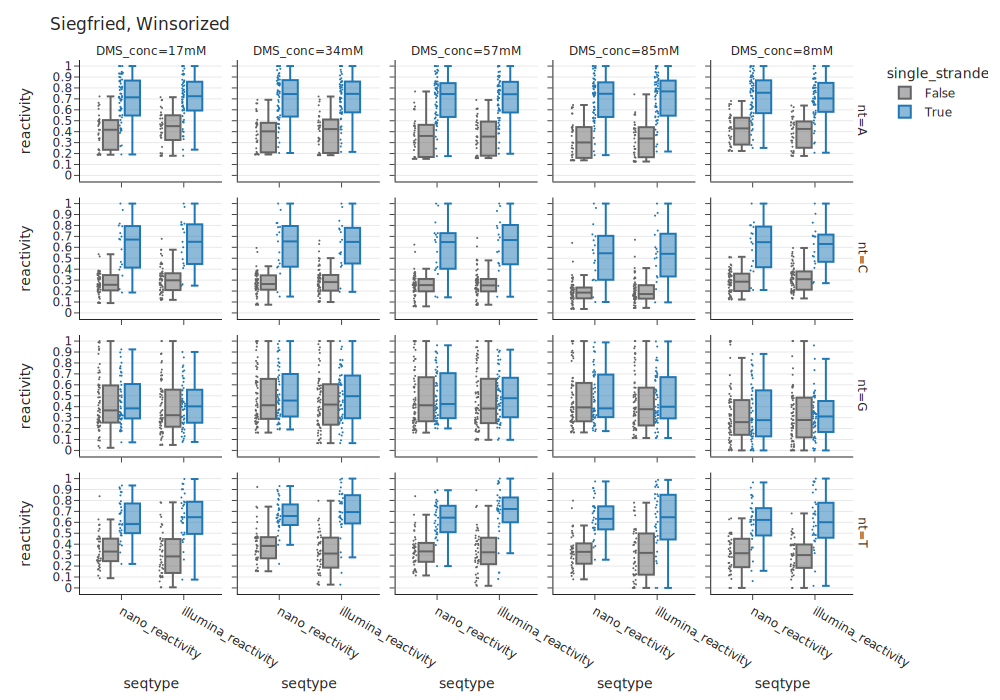

In [97]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Siegfried, Winsorized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.1)

#fig.write_image(f"figures/illumina_comparison/reactivity_box_ss_{filename}.svg")
fig.show()


In [98]:
corr_df = pd.DataFrame()
from scipy.stats import spearmanr
print("conc", "nt", "spearman", "", "pearson", sep="\t")
for DMS_conc in ["8mM", "17mM", "34mM", "57mM", "85mM"]:
    for nt in ["A", "C", "G", "T",  "AC", "ACGT"]:
        sub_df = merged_reactivity_df[(merged_reactivity_df["DMS_conc"] == DMS_conc) & (merged_reactivity_df["nt"].isin(list(nt)))].dropna()
        reactivity_1 = sub_df["nano_reactivity"].values
        reactivity_2 = sub_df["illumina_reactivity"].values
        spearman = spearmanr(reactivity_1, reactivity_2)[0]
        pearson = np.corrcoef(reactivity_1, reactivity_2)[0,1]
        print(DMS_conc, nt, spearman, pearson, sep="\t")
        tmp_df = pd.DataFrame([dict(DMS_conc = DMS_conc, nt = nt, norm_method = "Winsorizing", scoring_method = "Siegfried", spearman = spearman, pearson = pearson)])
        corr_df = pd.concat([corr_df, tmp_df])
    print("_______________________________________________________________")

conc	nt	spearman		pearson
8mM	A	0.8874990382958167	0.885747126103207
8mM	C	0.8608394445495376	0.9120531602464317
8mM	G	0.533379366119467	0.5471163572675383
8mM	T	0.6647960706764735	0.6746121895996748
8mM	AC	0.9178692397281631	0.9171581449735282
8mM	ACGT	0.7513354305624189	0.7638818661831701
_______________________________________________________________
17mM	A	0.935522411068717	0.9356405432059469
17mM	C	0.9221872910650524	0.9396640921606636
17mM	G	0.6472349584291884	0.6818446586336744
17mM	T	0.7564677697824773	0.7514723334025915
17mM	AC	0.9513595065347401	0.9496553788548924
17mM	ACGT	0.8088079017101866	0.824224669954338
_______________________________________________________________
34mM	A	0.9560751445642034	0.9549020872054695
34mM	C	0.9433747537420961	0.9614025198114347
34mM	G	0.8249640245880505	0.8293371523802265
34mM	T	0.7736927580110012	0.7624580253275778
34mM	AC	0.9700990159344437	0.966257923440447
34mM	ACGT	0.8805322790216005	0.8785602729463525
___________________________________

## Save data as excel

In [99]:
import os
os.makedirs("data_to_export", exist_ok=True)
filename = "siegfried_winsor"
corr_df.to_excel(f"data_to_export/nanopore_illumina_{minq}_correlations_{filename}.xlsx")


In [100]:
merged_reactivity_df.rename(columns = {"nano_reactivity" : "nanopore_reactivity"})[["sample", "DMS_conc", "position", "nt", "single_stranded", "nanopore_reactivity", "illumina_reactivity"]].to_excel(f"data_to_export/nanopore_illumina_{minq}_reactivity_{filename}.xlsx", na_rep='NaN', float_format = '%.6f')

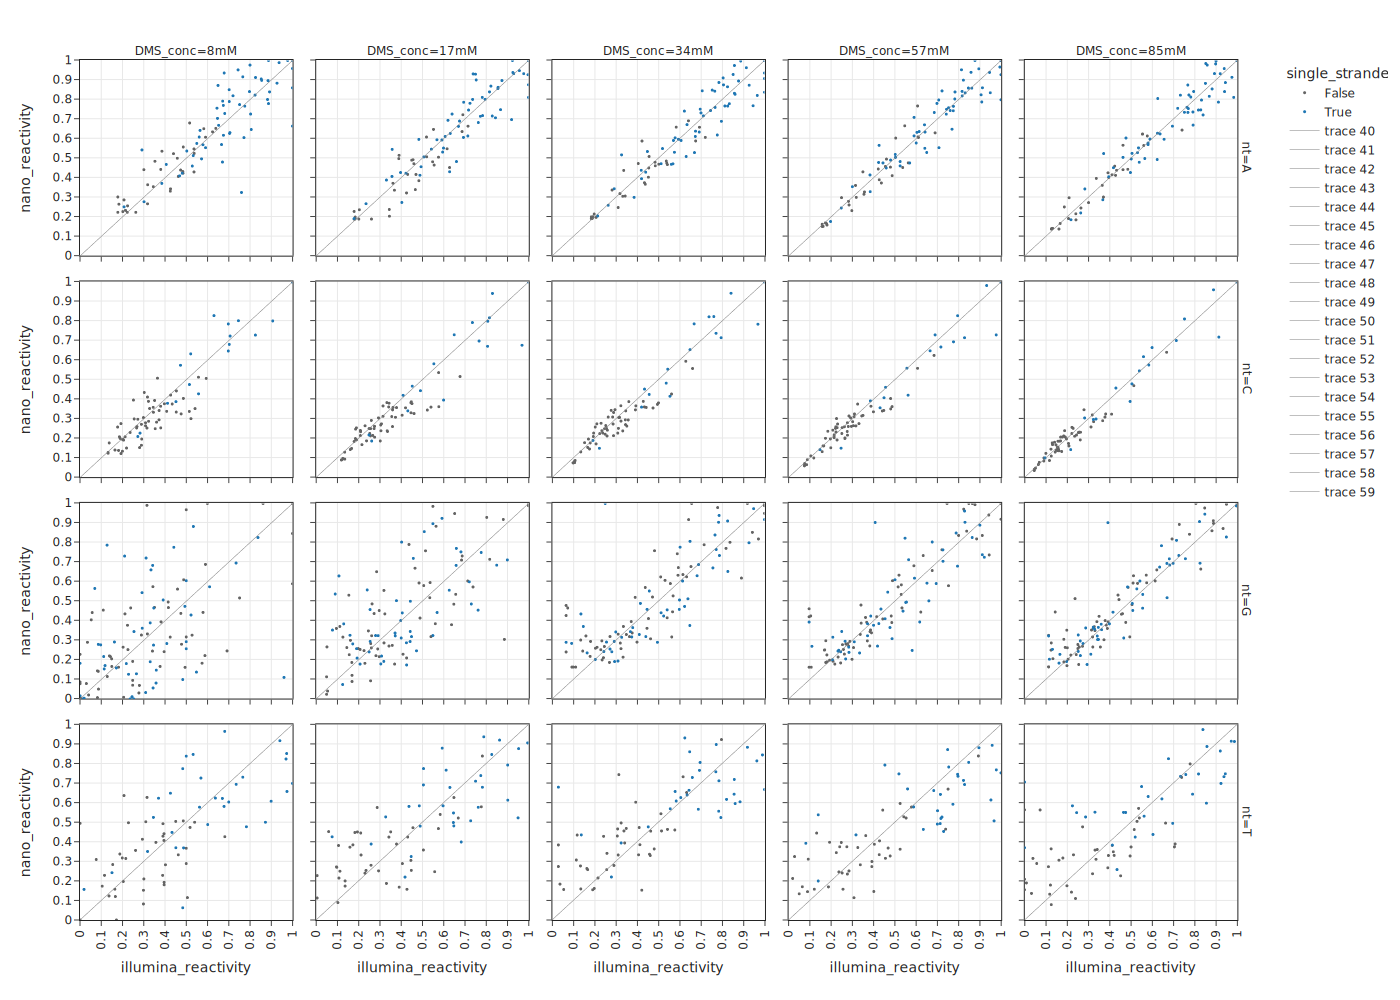

In [101]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1400, height=1000)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"
fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}.svg")
fig.show()

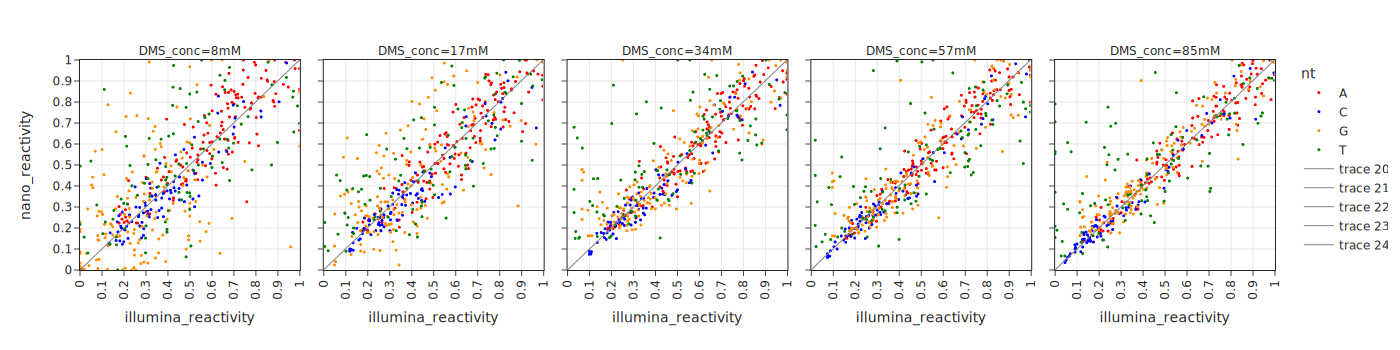

In [102]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="nt", category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = ["red", "blue", "darkorange", "green"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_nt_colored_combined.svg")
fig.show()

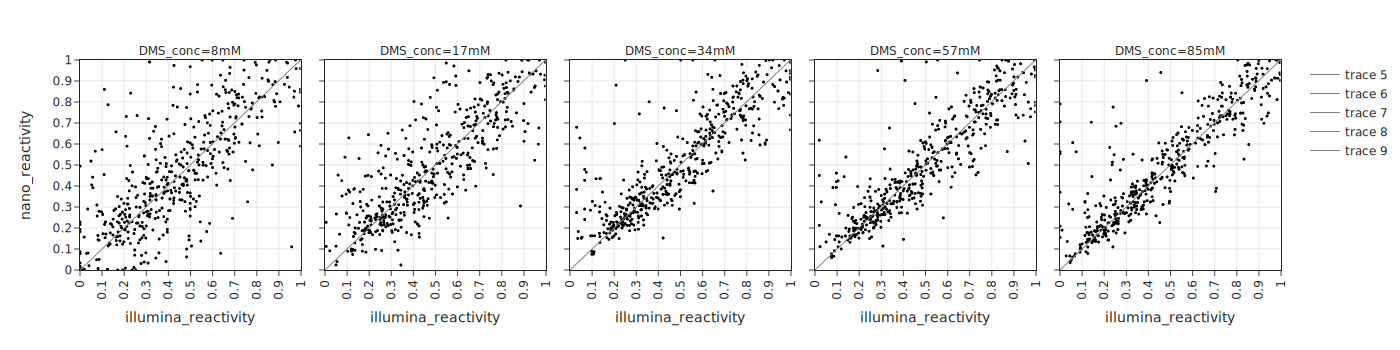

In [103]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc",  category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = ["black"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_all_nt_combined.svg")
fig.show()

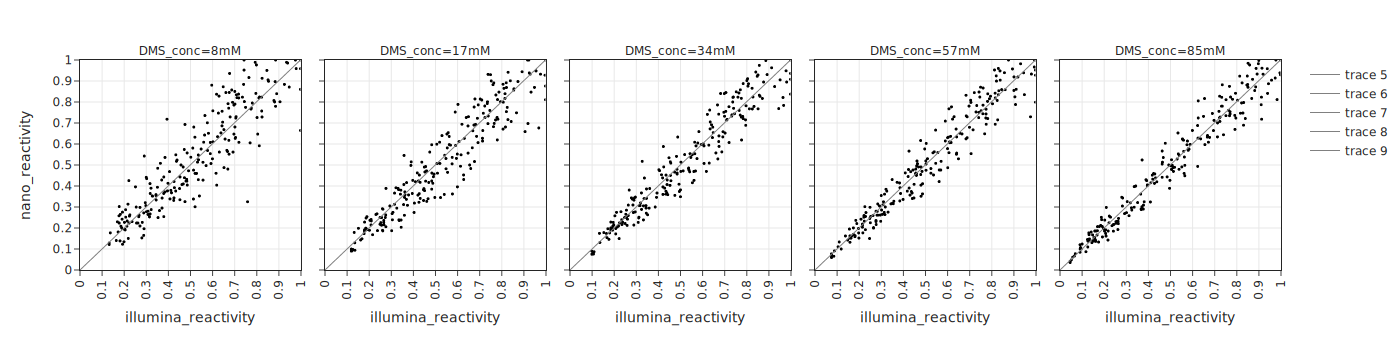

In [104]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df[merged_reactivity_df["nt"].isin(["A", "C"])], x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color_discrete_sequence = ["black"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_AC_combined.svg")
fig.show()

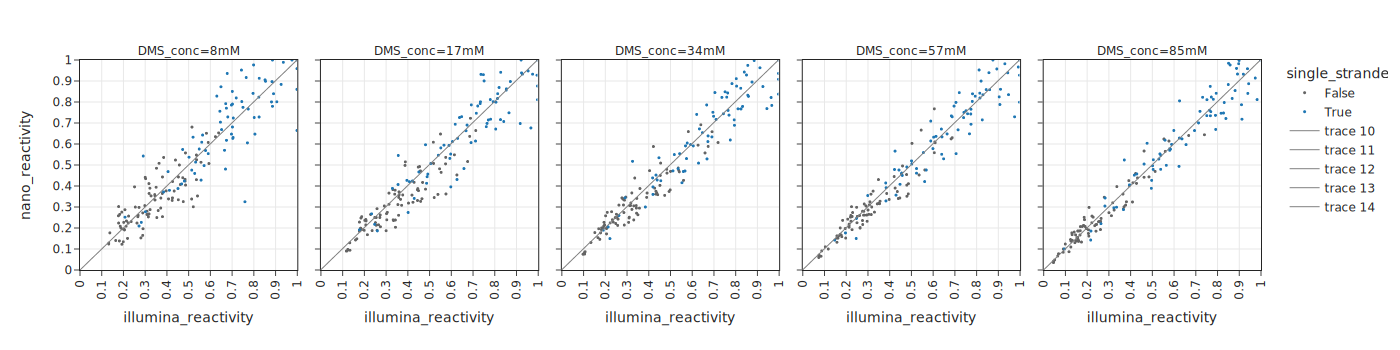

In [105]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df[merged_reactivity_df["nt"].isin(["A", "C"])], x="illumina_reactivity", y="nano_reactivity", category_orders = {"single_stranded" : [False, True]}, color="single_stranded", facet_col="DMS_conc")
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_AC_reactivity_scatter_ss_{filename}_AC_combined_ss.svg")
fig.show()

In [106]:
colorscale = pc.sequential.Plasma
print(colorscale)
colorscale = [colorscale[0]] + colorscale[3:8]
colorscale

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


['#0d0887', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a']

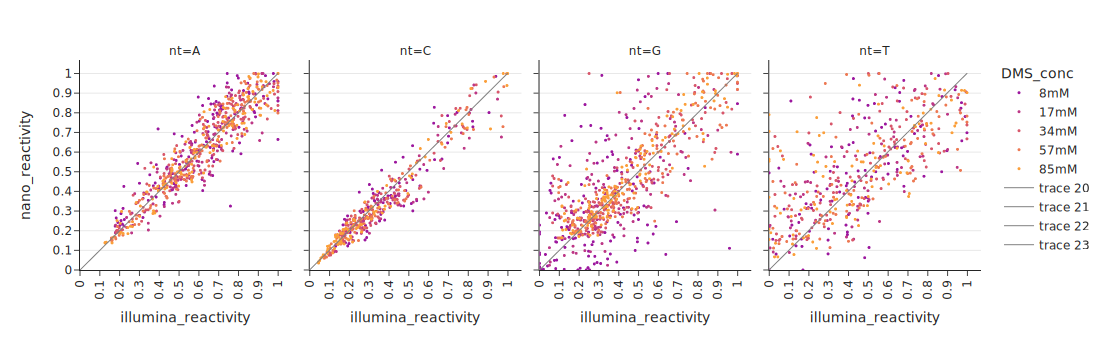

In [62]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", color="DMS_conc", facet_col="nt", category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = pc.sequential.Plasma[3:])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1100, height=350)
fig.update_xaxes(dtick=0.1)
fig.update_yaxes(dtick=0.1)
fig.update_traces(marker_size=3) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", tickangle=270)
fig.update_yaxes(rangemode="tozero")
fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_DMS_combined.svg")
fig.show()

## Illumina no read filtering

In [78]:
tmp_dfs = []

minq = "default"
for sample in samples:
    setting = "q22_eq10_ndni"
    nt = "ACGT"
    norm_option = ""
    
    xml = f"{data_folder}_illumina/rfcombine_bowtie/{minq}/{sample}/RT1_unspliced1/{setting}_{nt}{norm_option}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "illumina_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
illumina_reactivity_df = pd.concat(tmp_dfs)

Could not read in xml file /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data_illumina/rfcombine_bowtie/default/RT1_0mM_cell/RT1_unspliced1/q22_eq10_ndni_ACGT/RT1_unspliced1.xml from sample RT1_0mM_cell


In [79]:
nano_reactivity_df["sample_position"] = nano_reactivity_df["sample"] + "_" + nano_reactivity_df["position"]
illumina_reactivity_df["sample_position"] = illumina_reactivity_df["sample"] + "_" + illumina_reactivity_df["position"]
merged_reactivity_df = pd.merge(nano_reactivity_df, illumina_reactivity_df[["sample_position", "illumina_reactivity"]], on="sample_position")
merged_reactivity_df["DMS_conc"] = merged_reactivity_df["sample"].apply(lambda x: x.split("_")[1])
merged_reactivity_df["illumina_reactivity"] = merged_reactivity_df["illumina_reactivity"].astype(float)
merged_reactivity_df["nano_reactivity"] = merged_reactivity_df["nano_reactivity"].astype(float)
merged_reactivity_df["single_stranded"]  = merged_reactivity_df["position"].apply(lambda x: assign_structure(x))
melted_reactivity_df = pd.melt(merged_reactivity_df, id_vars=["sample_position", "nt", "DMS_conc", "single_stranded"], value_vars=["nano_reactivity", "illumina_reactivity"], var_name="seqtype", value_name='reactivity')

order_dict = {"nt" : ["A", "C", "G", "T"], "DMS_conc": ["8mM", "17mM", "34mM", "57mM", "85mM"]}

In [80]:
order_dict["DMS_conc"] = order_dict["DMS_conc"][1:]

In [81]:
melted_reactivity_df

sample_position nt DMS_conc single_stranded              seqtype  \
0        RT1_8mM_cell_1  G      8mM           False      nano_reactivity   
1        RT1_8mM_cell_2  G      8mM           False      nano_reactivity   
2        RT1_8mM_cell_3  T      8mM           False      nano_reactivity   
3        RT1_8mM_cell_4  C      8mM            True      nano_reactivity   
4        RT1_8mM_cell_5  T      8mM           False      nano_reactivity   
...                 ... ..      ...             ...                  ...   
5355  RT1_85mM_cell_532  C     85mM             NaN  illumina_reactivity   
5356  RT1_85mM_cell_533  A     85mM             NaN  illumina_reactivity   
5357  RT1_85mM_cell_534  T     85mM             NaN  illumina_reactivity   
5358  RT1_85mM_cell_535  C     85mM             NaN  illumina_reactivity   
5359  RT1_85mM_cell_536  C     85mM             NaN  illumina_reactivity   

      reactivity  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
5355         NaN  
5356         NaN  
5357         NaN  
5358         NaN  
5359         NaN  

[5360 rows x 6 columns]

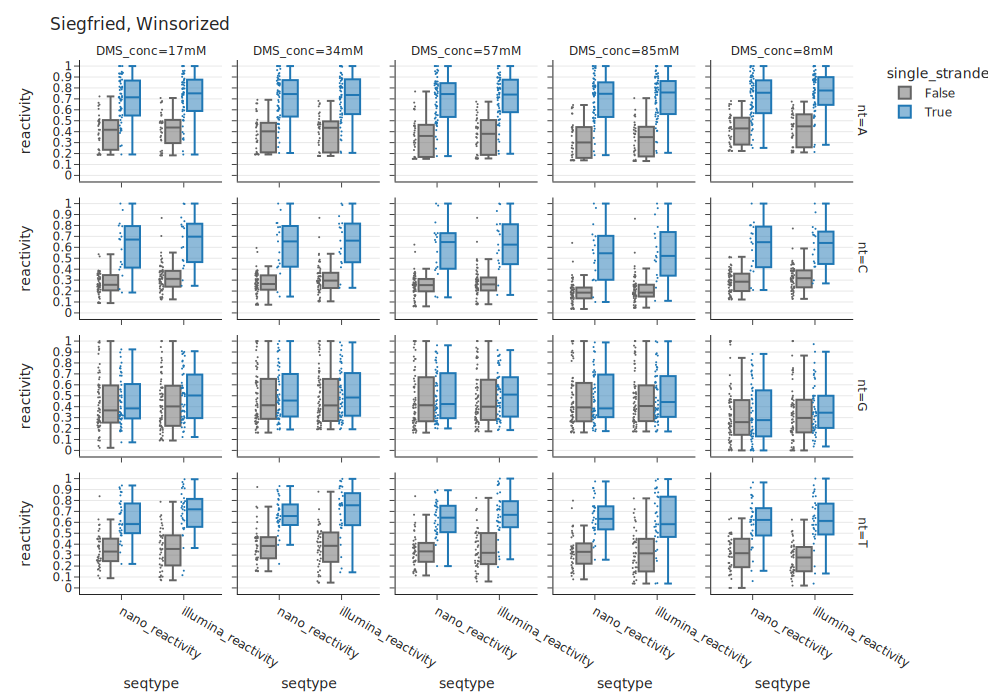

In [82]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Siegfried, Winsorized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.1)

#fig.write_image(f"figures/illumina_comparison/reactivity_box_ss_{filename}.svg")
fig.show()


In [83]:
corr_df = pd.DataFrame()
from scipy.stats import spearmanr
print("conc", "nt", "spearman", "", "pearson", sep="\t")
for DMS_conc in ["8mM", "17mM", "34mM", "57mM", "85mM"]:
    for nt in ["A", "C", "G", "T",  "AC", "ACGT"]:
        sub_df = merged_reactivity_df[(merged_reactivity_df["DMS_conc"] == DMS_conc) & (merged_reactivity_df["nt"].isin(list(nt)))].dropna()
        reactivity_1 = sub_df["nano_reactivity"].values
        reactivity_2 = sub_df["illumina_reactivity"].values
        spearman = spearmanr(reactivity_1, reactivity_2)[0]
        pearson = np.corrcoef(reactivity_1, reactivity_2)[0,1]
        print(DMS_conc, nt, spearman, pearson, sep="\t")
        tmp_df = pd.DataFrame([dict(DMS_conc = DMS_conc, nt = nt, norm_method = "Winsorizing", scoring_method = "Siegfried", spearman = spearman, pearson = pearson)])
        corr_df = pd.concat([corr_df, tmp_df])
    print("_______________________________________________________________")

conc	nt	spearman		pearson
8mM	A	0.9259179359744578	0.9248822691765346
8mM	C	0.9074213694247862	0.9353237408783232
8mM	G	0.5869360424939335	0.627339540105727
8mM	T	0.7545804626129193	0.7409962843881718
8mM	AC	0.9470129694659476	0.9458376981358131
8mM	ACGT	0.8000914733517795	0.8099834017865613
_______________________________________________________________
17mM	A	0.9407715483110782	0.9445553309364401
17mM	C	0.9145198230365448	0.9373968079286428
17mM	G	0.7606484293067189	0.7761498976162862
17mM	T	0.8117920395152554	0.7964695171633743
17mM	AC	0.9519530509101108	0.9506094480777078
17mM	ACGT	0.8600265269496231	0.8662317354368729
_______________________________________________________________
34mM	A	0.9558648474156956	0.9613955017561837
34mM	C	0.9419722882009974	0.9621098996469467
34mM	G	0.9148367187686512	0.9190299966876636
34mM	T	0.812753744388618	0.8036117795018575
34mM	AC	0.9688953886266509	0.9663892104484235
34mM	ACGT	0.9200981101297986	0.9179103644425034
________________________________

## Save data as excel

In [84]:
import os
os.makedirs("data_to_export", exist_ok=True)
filename = "siegfried_winsor"
corr_df.to_excel(f"data_to_export/nanopore_illumina_{minq}_correlations_{filename}.xlsx")


In [85]:
merged_reactivity_df.rename(columns = {"nano_reactivity" : "nanopore_reactivity"})[["sample", "DMS_conc", "position", "nt", "single_stranded", "nanopore_reactivity", "illumina_reactivity"]].to_excel(f"data_to_export/nanopore_illumina_{minq}_reactivity_{filename}.xlsx", na_rep='NaN', float_format = '%.6f')

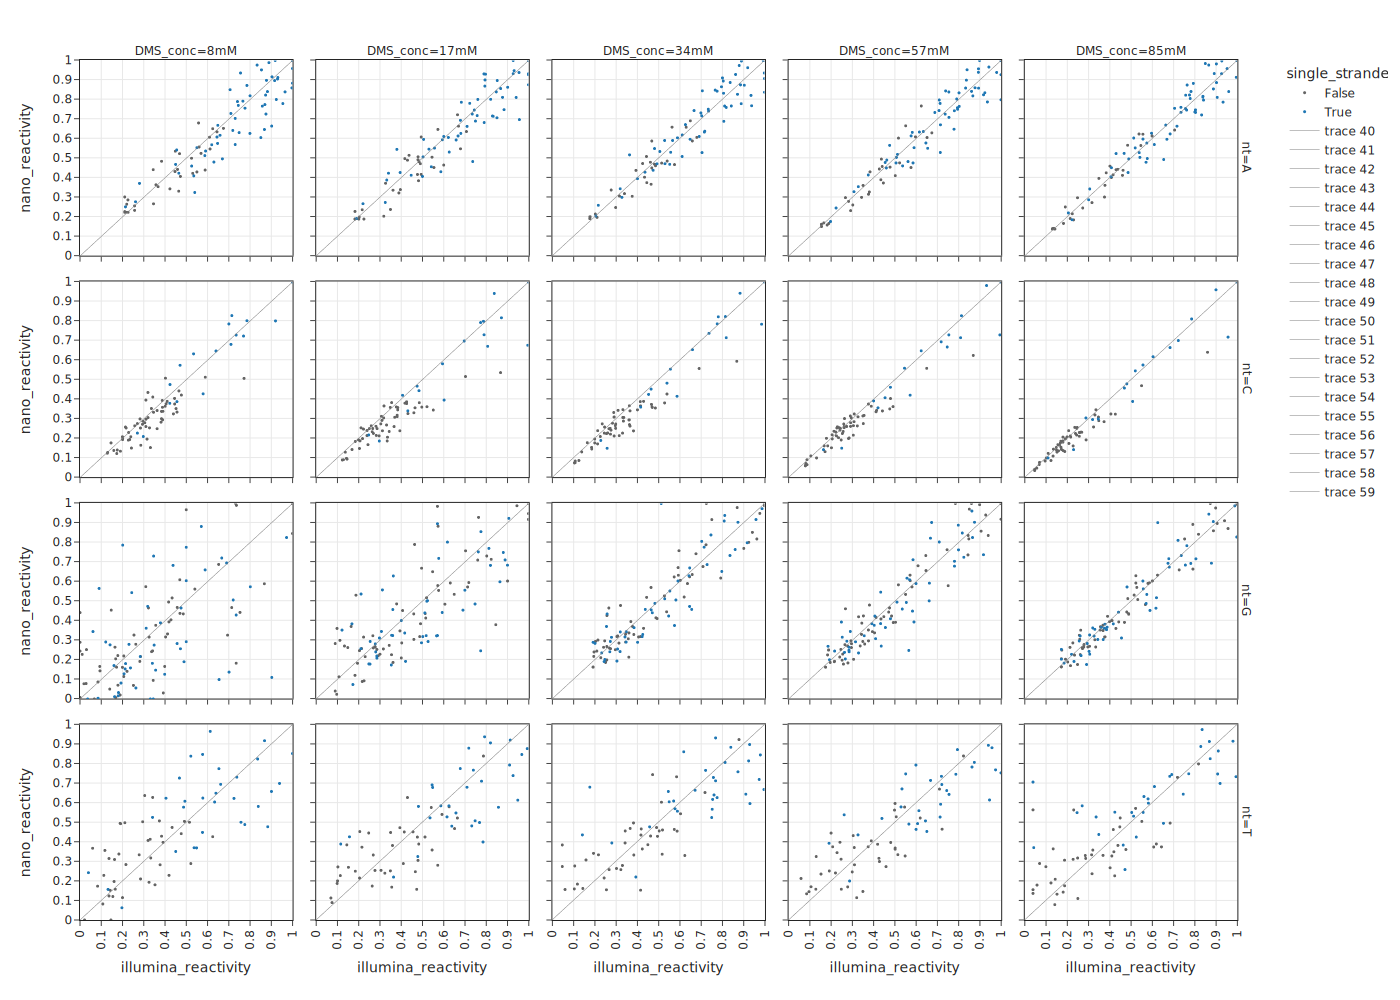

In [86]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1400, height=1000)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"
fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}.svg")
fig.show()

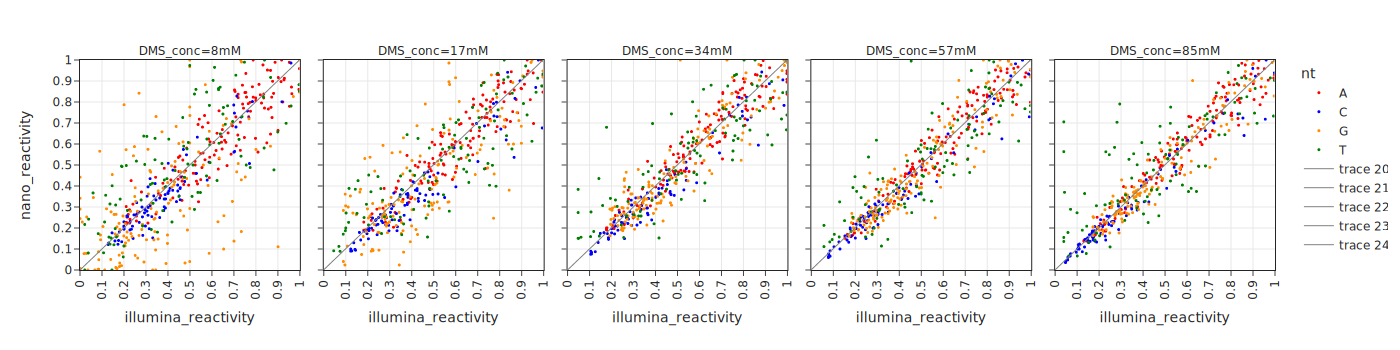

In [87]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="nt", category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = ["red", "blue", "darkorange", "green"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_nt_colored_combined.svg")
fig.show()

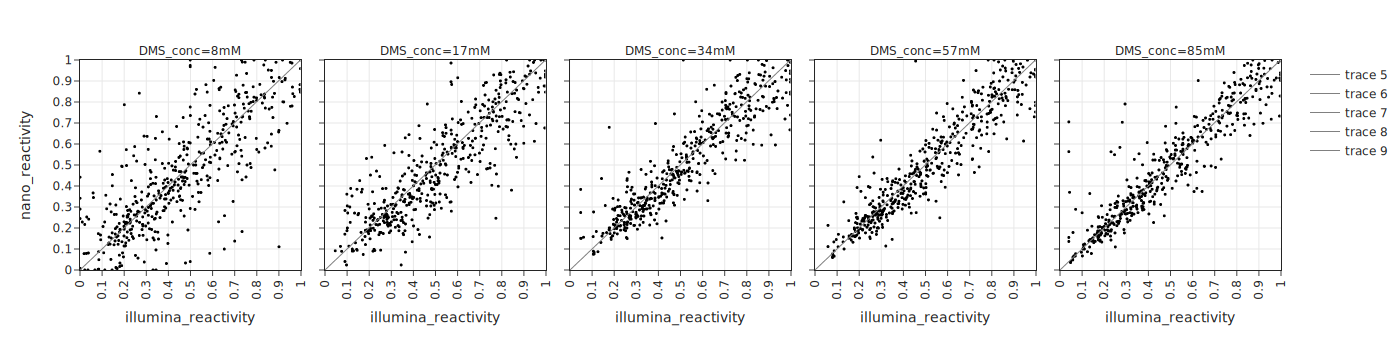

In [88]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc",  category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = ["black"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_all_nt_combined.svg")
fig.show()

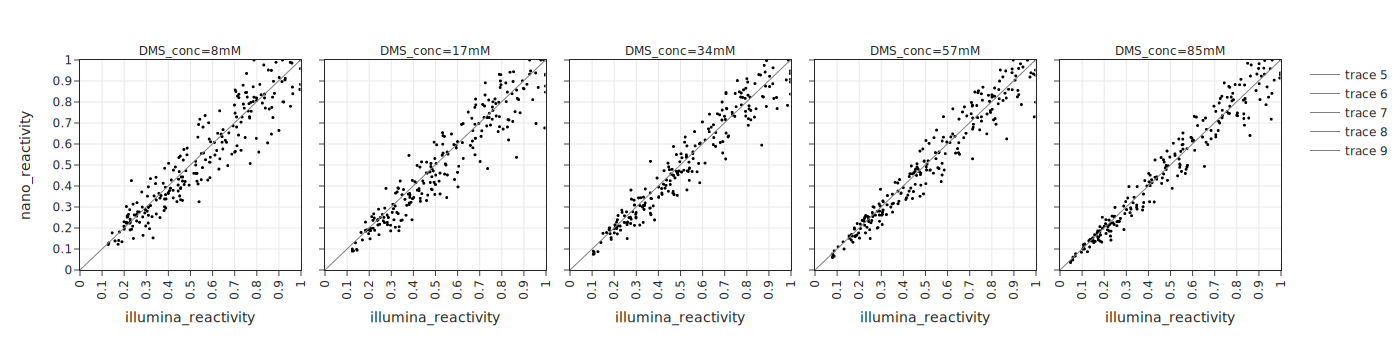

In [89]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df[merged_reactivity_df["nt"].isin(["A", "C"])], x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color_discrete_sequence = ["black"])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_AC_combined.svg")
fig.show()

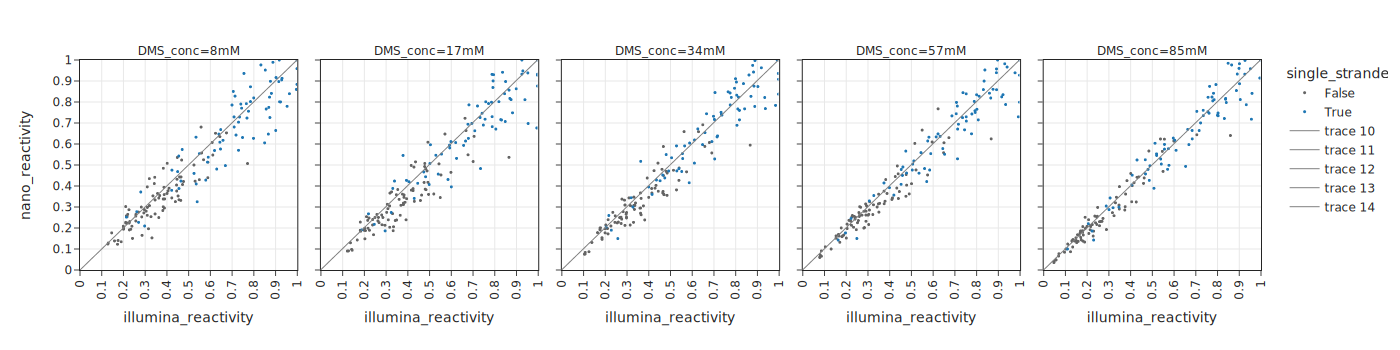

In [90]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df[merged_reactivity_df["nt"].isin(["A", "C"])], x="illumina_reactivity", y="nano_reactivity", category_orders = {"single_stranded" : [False, True]}, color="single_stranded", facet_col="DMS_conc")
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1400, height=350)
fig.update_xaxes(range=[0,1], dtick=0.1, rangemode="tozero", tickangle=270, showgrid=True, mirror=True,showline=True)
fig.update_yaxes(range=[0,1], dtick=0.1, rangemode="tozero", mirror=True,showline=True)
fig.update_traces(marker_size=3) #, marker_color="black"

fig.write_image(f"figures/nanopore_illumina_{minq}_AC_reactivity_scatter_ss_{filename}_AC_combined_ss.svg")
fig.show()

In [61]:
colorscale = pc.sequential.Plasma
print(colorscale)
colorscale = [colorscale[0]] + colorscale[3:8]
colorscale

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


['#0d0887', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a']

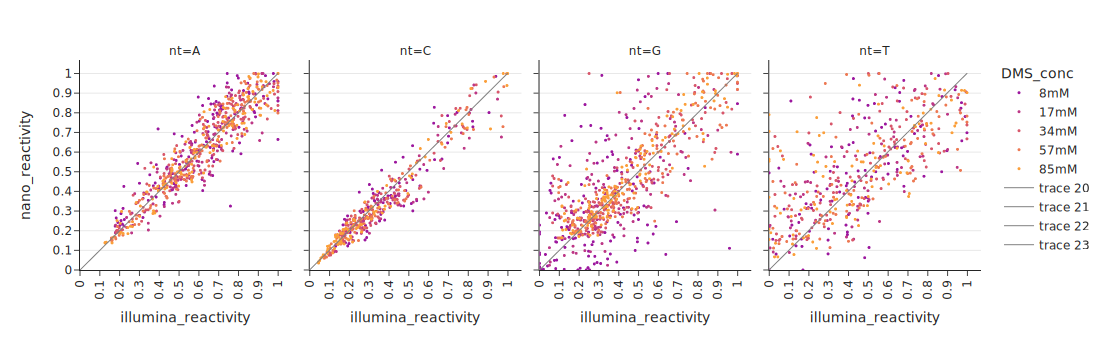

In [62]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", color="DMS_conc", facet_col="nt", category_orders = {"nt" : ["A", "C", "G", "T"]}, color_discrete_sequence = pc.sequential.Plasma[3:])
fig.add_trace(go.Scattergl(x=[0,1], y = [0, 1], mode="lines", line_color="grey", line_width=1), row="all", col="all")
fig.update_layout(width=1100, height=350)
fig.update_xaxes(dtick=0.1)
fig.update_yaxes(dtick=0.1)
fig.update_traces(marker_size=3) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", tickangle=270)
fig.update_yaxes(rangemode="tozero")
fig.write_image(f"figures/nanopore_illumina_{minq}_reactivity_scatter_ss_{filename}_DMS_combined.svg")
fig.show()

# Non-normalized reactivities (but using control)

In [ ]:
filename = "Siegfried_no_normalization"

In [ ]:
tmp_dfs = []
for sample in samples:
    nanopore_sample = "_".join(np.array(sample.split("_"))[[0, 3, 1, 2]])
    xml = f"rf_norm_combined_raw/{nanopore_sample}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "nano_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
nano_reactivity_df = pd.concat(tmp_dfs)

In [ ]:
tmp_dfs = []
for sample in samples:
    nanopore_sample = "_".join(np.array(illumina_sample.split("_"))[[0, 3, 1, 2]])
    xml = f"RT1_unspliced1_Illumina/rf_norm_combined_raw/{sample}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "illumina_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
illumina_reactivity_df = pd.concat(tmp_dfs)

In [ ]:
nano_reactivity_df["sample_position"] = nano_reactivity_df["sample"] + "_" + nano_reactivity_df["position"]
illumina_reactivity_df["sample_position"] = illumina_reactivity_df["sample"] + "_" + illumina_reactivity_df["position"]
merged_reactivity_df = pd.merge(nano_reactivity_df, illumina_reactivity_df[["sample_position", "illumina_reactivity"]], on="sample_position")
merged_reactivity_df["DMS_conc"] = merged_reactivity_df["sample"].apply(lambda x: x.split("_")[-1])
merged_reactivity_df["illumina_reactivity"] = merged_reactivity_df["illumina_reactivity"].astype(float)
merged_reactivity_df["nano_reactivity"] = merged_reactivity_df["nano_reactivity"].astype(float)
merged_reactivity_df["single_stranded"]  = merged_reactivity_df["position"].apply(lambda x: assign_structure(x))
melted_reactivity_df = pd.melt(merged_reactivity_df, id_vars=["sample_position", "nt", "DMS_conc", "single_stranded"], value_vars=["nano_reactivity", "illumina_reactivity"], var_name="seqtype", value_name='reactivity')

order_dict = {"nt" : ["A", "C", "G", "T"], "DMS_conc": ["0mM", "17mM", "34mM", "57mM", "85mM"]}

In [ ]:
order_dict["DMS_conc"] = order_dict["DMS_conc"][1:]

In [ ]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Siegfried, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.01)

fig.write_image(f"figures/illumina_comparison/reactivity_box_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Siegfried, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes( type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_ss_{filename}.svg")
fig.show()


In [ ]:
corr_df = pd.DataFrame()
from scipy.stats import spearmanr
print("conc", "nt", "spearman", "", "pearson", sep="\t")
for DMS_conc in ["17mM", "34mM", "57mM", "85mM"]:
    for nt in ["A", "C", "G", "T",  "AC", "ACGT"]:
        sub_df = merged_reactivity_df[(merged_reactivity_df["DMS_conc"] == DMS_conc) & (merged_reactivity_df["nt"].isin(list(nt)))].dropna()
        reactivity_1 = sub_df["nano_reactivity"].values
        reactivity_2 = sub_df["illumina_reactivity"].values
        spearman = spearmanr(reactivity_1, reactivity_2)[0]
        pearson = np.corrcoef(reactivity_1, reactivity_2)[0,1]
        print(DMS_conc, nt, spearman, pearson, sep="\t")
        tmp_df = pd.DataFrame([dict(DMS_conc = DMS_conc, nt = nt, norm_method = "Winsorizing", scoring_method = "Zubradt", spearman = spearman, pearson = pearson)])
        corr_df = pd.concat([corr_df, tmp_df])
    print("_______________________________________________________________")

## Save data as excel

In [ ]:
corr_df.to_excel(f"data_to_export/illumina_comparison/correlations_{filename}.xlsx")


In [ ]:
merged_reactivity_df.rename(columns = {"nano_reactivity" : "nanopore_reactivity"})[["sample", "DMS_conc", "position", "nt", "single_stranded", "nanopore_reactivity", "illumina_reactivity"]].to_excel(f"data_to_export/illumina_comparison/reactivity_{filename}.xlsx", na_rep='NaN', float_format = '%.6f')

In [ ]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0,0.06], y = [0, .06], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1100, height=1000)
fig.update_xaxes(dtick=0.01)
fig.update_yaxes(dtick=0.01)
fig.update_traces(marker_size=3) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", tickangle=270)
fig.update_yaxes(rangemode="tozero")
fig.write_image(f"figures/illumina_comparison/reactivity_scatter_ss_{filename}.svg")
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0.00005,0.06], y = [0.00005, .06], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1100, height=1000)
#fig.update_xaxes(dtick=0.01)
#fig.update_yaxes(dtick=0.01)
fig.update_traces(marker_size=2.5) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", type="log", range = [-4, -1], tickangle=270)
fig.update_yaxes(rangemode="tozero", type="log", range = [-4,-1])
fig.write_image(f"figures/illumina_comparison/reactivity_scatter_log_ss_{filename}.svg")
fig.show()

# Non-normalized reactivities (wo control, i.e. mutation rates)

In [ ]:
rf_norm_dir = "rf_norm_combined_raw_no_control"

In [ ]:
filename = "Zubradt_no_normalization"

In [ ]:
tmp_dfs = []
for sample in samples:
    nanopore_sample = "_".join(np.array(sample.split("_"))[[0, 3, 1, 2]])
    xml = f"{rf_norm_dir}/{nanopore_sample}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "nano_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
nano_reactivity_df = pd.concat(tmp_dfs)

In [ ]:
rf_norm_dir = "rfnorm_raw_combined"

In [ ]:
tmp_dfs = []
for sample in samples:
    nanopore_sample = "_".join(np.array(illumina_sample.split("_"))[[0, 3, 1, 2]])
    xml = f"RT1_unspliced1_Illumina/{rf_norm_dir}/{sample}/RT1_unspliced1.xml"

    tmp_df = xml_to_df(xml, "illumina_reactivity")
    if tmp_df is not None:
        tmp_df["sample"] = sample
        tmp_dfs.append(tmp_df)
    
illumina_reactivity_df = pd.concat(tmp_dfs)

In [ ]:
nano_reactivity_df["sample_position"] = nano_reactivity_df["sample"] + "_" + nano_reactivity_df["position"]
illumina_reactivity_df["sample_position"] = illumina_reactivity_df["sample"] + "_" + illumina_reactivity_df["position"]
merged_reactivity_df = pd.merge(nano_reactivity_df, illumina_reactivity_df[["sample_position", "illumina_reactivity"]], on="sample_position")
merged_reactivity_df["DMS_conc"] = merged_reactivity_df["sample"].apply(lambda x: x.split("_")[-1])
merged_reactivity_df["illumina_reactivity"] = merged_reactivity_df["illumina_reactivity"].astype(float)
merged_reactivity_df["nano_reactivity"] = merged_reactivity_df["nano_reactivity"].astype(float)
merged_reactivity_df["single_stranded"]  = merged_reactivity_df["position"].apply(lambda x: assign_structure(x))
melted_reactivity_df = pd.melt(merged_reactivity_df, id_vars=["sample_position", "nt", "DMS_conc", "single_stranded"], value_vars=["nano_reactivity", "illumina_reactivity"], var_name="seqtype", value_name='reactivity')

order_dict = {"nt" : ["A", "C", "G", "T"], "DMS_conc": ["0mM", "8mM", "17mM", "34mM", "57mM", "85mM"]}

In [ ]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.01, range = [0,0.1])

fig.write_image(f"figures/illumina_comparison/reactivity_box_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, facet_col="seqtype", x="DMS_conc", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.01, range = [0,0.1])

fig.write_image(f"figures/illumina_comparison/reactivity_box_facet_seqtype_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, facet_col="seqtype", x="DMS_conc", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_facet_seqtype_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, color="seqtype", x="DMS_conc", y="reactivity", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_color_seqtype_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, color="DMS_conc", x="seqtype", y="reactivity", facet_row="nt", points="all", color_discrete_sequence =colorscale,  category_orders=order_dict)
fig.update_layout(height=700, width=1000, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_color_DMS_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, color="seqtype", x="DMS_conc", y="reactivity", facet_col="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1400, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes(dtick=0.01, range = [0,0.1])

fig.write_image(f"figures/illumina_comparison/reactivity_box_facet_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1200, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes( type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_ss_{filename}.svg")
fig.show()


In [ ]:
fig = px.box(melted_reactivity_df, facet_col="DMS_conc", x="seqtype", y="reactivity", color="single_stranded", facet_row="nt", points="all",  category_orders=order_dict)
fig.update_layout(height=700, width=1200, title ="Zubradt, not normalized")
fig.update_traces(marker_size=2)
fig.update_yaxes( type="log")

fig.write_image(f"figures/illumina_comparison/reactivity_box_log_ss_{filename}.svg")
fig.show()


In [ ]:
corr_df = pd.DataFrame()
from scipy.stats import spearmanr
print("conc", "nt", "spearman", "", "pearson", sep="\t")
for DMS_conc in ["17mM", "34mM", "57mM", "85mM"]:
    for nt in ["A", "C", "G", "T",  "AC", "ACGT"]:
        sub_df = merged_reactivity_df[(merged_reactivity_df["DMS_conc"] == DMS_conc) & (merged_reactivity_df["nt"].isin(list(nt)))].dropna()
        reactivity_1 = sub_df["nano_reactivity"].values
        reactivity_2 = sub_df["illumina_reactivity"].values
        spearman = spearmanr(reactivity_1, reactivity_2)[0]
        pearson = np.corrcoef(reactivity_1, reactivity_2)[0,1]
        print(DMS_conc, nt, spearman, pearson, sep="\t")
        tmp_df = pd.DataFrame([dict(DMS_conc = DMS_conc, nt = nt, norm_method = "None", scoring_method = "Zubradt", spearman = spearman, pearson = pearson)])
        corr_df = pd.concat([corr_df, tmp_df])
    print("_______________________________________________________________")

## Save data as excel

In [ ]:
corr_df.to_excel(f"data_to_export/illumina_comparison/correlations_{filename}.xlsx")


In [ ]:
merged_reactivity_df.rename(columns = {"nano_reactivity" : "nanopore_reactivity"})[["sample", "DMS_conc", "position", "nt", "single_stranded", "nanopore_reactivity", "illumina_reactivity"]].to_excel(f"data_to_export/illumina_comparison/reactivity_{filename}.xlsx", na_rep='NaN', float_format = '%.6f')

In [ ]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0,0.1], y = [0, 0.1], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1100, height=1000)
fig.update_xaxes(dtick=0.01, range = [0,0.1])
fig.update_yaxes(dtick=0.01, range = [0,0.1])
fig.update_traces(marker_size=3) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", tickangle=270)
fig.update_yaxes(rangemode="tozero")
fig.write_image(f"figures/illumina_comparison/reactivity_scatter_ss_{filename}.svg")
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = px.scatter(merged_reactivity_df, x="illumina_reactivity", y="nano_reactivity", facet_col="DMS_conc", color="single_stranded", facet_row="nt", category_orders = {"nt" : ["A", "C", "G", "T"]})
fig.add_trace(go.Scattergl(x=[0.00005,0.1], y = [0.00005, .1], mode="lines", line_color="grey", line_width=0.5), row="all", col="all")
fig.update_layout(width=1100, height=1000)
#fig.update_xaxes(dtick=0.01)
#fig.update_yaxes(dtick=0.01)
fig.update_traces(marker_size=2.5) #, marker_color="black"
fig.update_xaxes(rangemode="tozero", type="log", range = [-4, -1], tickangle=270)
fig.update_yaxes(rangemode="tozero", type="log", range = [-4,-1])
fig.write_image(f"figures/illumina_comparison/reactivity_scatter_log_ss_{filename}.svg")
fig.show()